In [1]:
import tensorflow as tf
from keras.models import Model
from keras.applications import MobileNetV2, ResNet50, InceptionV3 # try to use them and see which is better
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.utils import get_file
from keras.preprocessing.image import ImageDataGenerator
import os
import pathlib
import numpy as np

Using TensorFlow backend.


In [2]:
batch_size = 32
# 5 types of flowers
num_classes = 42
# training for 10 epochs
epochs = 40
# size of each image
IMAGE_SHAPE = (224, 224, 3)

In [3]:
data_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
data_dir = pathlib.Path(data_dir)
print(data_dir)
# count how many images are there
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count
#data_dir.glob("*/*.jpg")
#glob.glob('*/*.jpg')
#image_count = len(list(os.listdir(data_dir('*/*.jpg'))))
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
len(CLASS_NAMES)

/Users/priya/Desktop/classes-master/shopee_product_detection/data/train


42

In [11]:
#This function extracts the dataset, and then uses the ImageDataGenerator keras utility class 
#to wrap the dataset in a Python generator (so the images only loads to memory by batches, not in one shot).

def load_data(data_dir):
    """This function downloads, extracts, loads, normalizes and one-hot encodes Flower Photos dataset"""
    # download the dataset and extract it
    #data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    #                                     fname='flower_photos', untar=True)
    #data_dir = pathlib.Path(data_dir)
    #data_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
    data_dir = pathlib.Path(data_dir)
    # count how many images are there
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print("Number of images:", image_count)
    # get all classes for this dataset (types of items) excluding .DS_Store file #folders are classes
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
    # 20% validation set 80% training set
    image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    # make the training dataset generator
    train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="training")
    # make the validation dataset generator
    test_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="validation")
    return train_data_gen, test_data_gen, CLASS_NAMES

In [5]:
def create_model(input_shape):
    # load MobileNetV2
    model = MobileNetV2(input_shape=input_shape)
    # remove the last fully connected layer
    model.layers.pop()
    # freeze all the weights of the model except the last 4 layers
    for layer in model.layers[:-4]:
        layer.trainable = False
    # construct our own fully connected layer for classification
    output = Dense(num_classes, activation="softmax")
    # connect that dense layer to the model
    output = output(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=output)
    # print the summary of the model architecture
    model.summary()
    # training the model using rmsprop optimizer
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [8]:
batch_size = 32
# 5 types of flowers
num_classes = 42
# training for 10 epochs
epochs = 40
# size of each image
IMAGE_SHAPE = (224, 224, 3)

In [9]:
#from keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#filepath = 'full_data_ep{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stops = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=0)
callbacks = [checkpoint,early_stops]

data_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'

if __name__ == "__main__":
    val_loss = []
    validation_loss = []
    # load the data generators
    train_generator, validation_generator, class_names = load_data(data_dir)
    # constructs the model
    model = create_model(input_shape=IMAGE_SHAPE)
    # model name
    model_name = "MobileNetV2_finetune_last5"
    # some nice callbacks
    tensorboard = TensorBoard(log_dir=f"logs/{model_name}")
    filepath = '{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    #checkpoint = ModelCheckpoint(f"results/{model_name}" + "-loss-{val_loss:.2f}-acc-{val_acc:.2f}.h5",
    #                            save_best_only=True,
    #                            verbose=1)
    # make sure results folder exist
    if not os.path.isdir("results"):
        os.mkdir("results")
    # count number of steps per epoch
    training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
    validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
    # train using the generators
    history = model.fit_generator(train_generator, steps_per_epoch=training_steps_per_epoch,
                        validation_data=validation_generator, validation_steps=validation_steps_per_epoch,
                        epochs=epochs, verbose=1, callbacks=[checkpoint,early_stops])
    
    val_loss.append(history.history['val_loss'][0])
    print("{} val_loss is {}".format(epochs,val_loss))
    
    validation_loss = history.history['val_loss'][0]
    print("{} validation_loss is {}".format(epochs,validation_loss))

Number of images: 105392
Found 84331 images belonging to 42 classes.
Found 21061 images belonging to 42 classes.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]  

Epoch 1/40
2636/2636 [==============================] - ETA: 0s - loss: 2.9525 - accuracy: 0.3471
Epoch 00001: val_loss improved from inf to 2.40366, saving model to 001_acc0.347_loss2.953_val_acc0.375_val_loss2.404.h5
2636/2636 [==============================] - 1995s 757ms/step - loss: 2.9525 - accuracy: 0.3471 - val_loss: 2.4037 - val_accuracy: 0.3751
Epoch 2/40
2636/2636 [==============================] - ETA: 0s - loss: 2.1642 - accuracy: 0.3862
Epoch 00002: val_loss improved from 2.40366 to 2.02121, saving model to 002_acc0.386_loss2.164_val_acc0.393_val_loss2.021.h5
2636/2636 [==============================] - 1735s 658ms/step - loss: 2.1642 - accuracy: 0.3862 - val_loss: 2.0212 - val_accuracy: 0.3933
Epoch 3/40
2636/2636 [==============================] - ETA: 0s - loss: 1.9298 - accuracy: 0.3992
Epoch 00003: val_loss improved from 2.02121 to 1.92726, saving model to 003_acc0.399_loss1.930_val_acc0.394_val_loss1.927.h5
2636/2636 [==============================] - 1737s 659ms/st

In [10]:
history.history['val_loss']

[2.403658390045166,
 2.021214008331299,
 1.9272593259811401,
 1.8690770864486694,
 1.8721364736557007]

In [14]:
data_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
# load the data generators
train_generator, validation_generator, class_names = load_data(data_dir)
# constructs the model
model = create_model(input_shape=IMAGE_SHAPE)
# load the optimal weights
model.load_weights("010_acc0.483_loss1.559_val_acc0.460_val_loss1.714.h5")
validation_steps_per_epoch = np.ceil(validation_generator.samples / batch_size)
# print the validation loss & accuracy
evaluation = model.evaluate_generator(validation_generator, steps=validation_steps_per_epoch, verbose=1)
print("Val loss:", evaluation[0])
print("Val Accuracy:", evaluation[1])

Number of images: 105392
Found 84331 images belonging to 42 classes.
Found 21061 images belonging to 42 classes.
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]  

659/659 [==============================] - 317s 481ms/step - loss: 1.7132 - accuracy: 0.4604
Val loss: 1.713152289390564
Val Accuracy: 0.4604244828224182


# Method 2

In [124]:
import pandas as pd
from keras.utils import to_categorical
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.applications import MobileNetV2, ResNet50, InceptionV3 # try to use them and see which is better
from keras.models import Model

In [125]:
train = pd.read_csv('../data/train.csv')
train.head()

,filename,category
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3
2,f6c172096818c5fab10ecae722840798.jpg,3
3,251ffd610399ac00fea7709c642676ee.jpg,3
4,73c7328b8eda399199fdedec6e4badaf.jpg,3


In [126]:
train_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
train['path'] = train_dir + train['category'].apply(lambda x: str(x)+"/" if len(str(x))>1 else "0"+str(x)+"/") + train['filename'].apply(lambda x: x)
train.head()

,filename,category,path
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...
2,f6c172096818c5fab10ecae722840798.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...
3,251ffd610399ac00fea7709c642676ee.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...
4,73c7328b8eda399199fdedec6e4badaf.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...


In [127]:
train['category'].nunique()

42

In [145]:
new_train = pd.concat([train,pd.get_dummies(train['category'],prefix="category")],axis=1)

In [146]:
new_train.head()

,filename,category,path,category_0,category_1,category_2,category_3,category_4,category_5,category_6,...,category_32,category_33,category_34,category_35,category_36,category_37,category_38,category_39,category_40,category_41
0,45e2d0c97f7bdf8cbf3594beb6fdcda0.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,f74d1a5fc2498bbbfa045c74e3cc333e.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,f6c172096818c5fab10ecae722840798.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,251ffd610399ac00fea7709c642676ee.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,73c7328b8eda399199fdedec6e4badaf.jpg,3,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [147]:
#train = pd.get_dummies(train,columns=['category'])
#train.tail()
#pd.get_dummies(df, columns=['Embarked'])
#new_train.dtypes

In [150]:
columns = [x for x in new_train.columns if "category_" in x]
columns[:2]

['category_0', 'category_1']

In [118]:
#train['y_vector'][0].tolist() # converts numpy array to list
#train['y_vector'] = train['category'].apply(lambda x: (np.pad(to_categorical(x), (0, 42-len(to_categorical(x))), 'constant', constant_values=0.0)).tolist())
#train.head()

In [115]:
#train[train['category']==5]

In [167]:
test = pd.read_csv('../data/test.csv')
test.head()
test_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/test/'
test['path'] = test_dir + test['filename'].apply(lambda x: x)
test.head()

,filename,category,path
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
2,127f3e6d6e3491b2459812353f33a913.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...
4,46d681a542f2c71be017eef6aae23313.jpg,43,/Users/priya/Desktop/classes-master/shopee_pro...


In [152]:
test['path'][0]

'/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/fd663cf2b6e1d7b02938c6aaae0a32d2.jpg'

In [168]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(new_train, test_size=0.25, random_state=42,
                                    stratify=new_train['category'])
print(train_df.shape, 'training data')
print(valid_df.shape, 'validation data')

(79044, 45) training data
(26348, 45) validation data


In [157]:
#train.dtypes
#train['category'] = train['category'].astype(str)
#train.dtypes

In [51]:
# get the labels in the right format
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#class_enc = LabelEncoder()
#train['category'] = class_enc.fit_transform(train['category'])
#train.head()
#oh_enc = OneHotEncoder(sparse=False)
#train['category_vec'] = oh_enc.fit_transform(
#    train['category'].values.reshape(-1, 1)).tolist() 
#train.head()


In [158]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [159]:
from tensorflow.keras.applications.mobilenet import MobileNet as PTModel,preprocess_input
def prepare_image(file):
    img = load_img(file, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    print(preprocess_input(img_array_expanded_dims).shape)
    return preprocess_input(img_array_expanded_dims)

In [15]:
#prepare_image('/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/fd663cf2b6e1d7b02938c6aaae0a32d2.jpg')

In [170]:
valid_df.head()

,filename,category,path,category_0,category_1,category_2,category_3,category_4,category_5,category_6,...,category_32,category_33,category_34,category_35,category_36,category_37,category_38,category_39,category_40,category_41
47734,724f72531c9fb013dca2f26c5d418dd2.jpg,7,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80888,57ba3d1a2bd1d9845b5c82300412a7d6.jpg,41,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10865,6383c74eda58ba95e484f62e19de9194.jpg,34,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
16611,5c5a85a2c9840c81a3b47f03e5d91301.jpg,2,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100334,8f438732654b1aada9c91d466aabee4b.jpg,22,/Users/priya/Desktop/classes-master/shopee_pro...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
IMG_SHAPE = (224, 224, 3)

img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)

In [178]:
#datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25,**img_gen_args)
datagen=ImageDataGenerator(rescale=1./255.,**img_gen_args)

In [179]:
train_generator=datagen.flow_from_dataframe(
dataframe=train_df,
#directory="./train/", #(str)Path to the directory which contains all the images.
#set this to None if your x_col contains absolute_paths pointing to each image files instead of just filenames.
x_col="path",
y_col=columns, # contains the class names. None in test_generator
#subset="training",
batch_size=32,
color_mode='rgb',
seed=42,
shuffle=True, #Set this to False(For Test generator only, for others set True),
class_mode="raw", # (str) Similar to flow_from_directory, 
#this accepts “categorical”(default), ”binary”, ”sparse”, ”input”, None and also an extra argument “raw”.
target_size=(224,224),
#classes=None
#validate_filenames=True
)

valid_generator=datagen.flow_from_dataframe(
dataframe=valid_df,
#directory="./train/",
x_col="path",
y_col=columns,
#subset="validation", #if division is done in ImageDataGenerator
color_mode='rgb',
batch_size=32,
seed=42,
shuffle=True,
class_mode="raw",
target_size=(224,224))

test_datagen=ImageDataGenerator(rescale=1./255.,**img_gen_args)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
#directory="./test/",
x_col="path",
y_col=None, ## contains the class names. None in test_generator
batch_size=18, #Set this to some number that divides your total number of images in your test set exactly.
seed=42,
shuffle=False, #Set this to False(For Test generator only, for others set True),
class_mode=None, # None since we are predicting classes
target_size=(224,224))

Found 79044 validated image filenames.
Found 26348 validated image filenames.
Found 12186 validated image filenames.


In [180]:
from keras.applications import MobileNetV2, ResNet50, InceptionV3,Xception
IMG_SHAPE=(299,299,3)
base_pretrained_model = Xception(input_shape =  IMG_SHAPE, 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

In [181]:
base_pretrained_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [182]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model
from keras.optimizers import Adam
from keras import layers

DROPOUT = 0.25
DENSE_COUNT = 128

pt_features = Input(base_pretrained_model.get_output_shape_at(0)[1:], name = 'feature_input')
#pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

gap = GlobalAveragePooling2D()(bn_features)

gap_dr = Dropout(DROPOUT)(gap)
dr_steps = Dropout(DROPOUT)(Dense(DENSE_COUNT, activation = 'linear', use_bias=False)(gap_dr))
dr_steps = BatchNormalization()(dr_steps)
dr_steps = layers.LeakyReLU(0.1)(dr_steps)
out_layer = Dense(42, activation = 'softmax')(dr_steps)

attn_model = Model(inputs = [pt_features], 
                   outputs = [out_layer], name = 'trained_model')

attn_model.summary()

Model: "trained_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_input (InputLayer)   [(None, 10, 10, 2048)]    0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 10, 10, 2048)      8192      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               262144    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 128)             

In [183]:
LEARN_RATE = 0.01 # 0.0001
from keras.models import Sequential
from keras.optimizers import Adam
pneu_model = Sequential(name = 'combined_model')
base_pretrained_model.trainable = False
pneu_model.add(base_pretrained_model)
pneu_model.add(attn_model)
pneu_model.compile(optimizer = Adam(lr = LEARN_RATE), loss = 'categorical_crossentropy',metrics = ['accuracy'])
                           #metrics = ['categorical_accuracy'])
pneu_model.summary()

Model: "combined_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
trained_model (Model)        (None, 42)                276266    
Total params: 21,137,746
Trainable params: 271,914
Non-trainable params: 20,865,832
_________________________________________________________________


In [184]:
#BATCH_SIZE=24

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stops = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=10)

filepath = '{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [checkpoint,early_stops]

train_generator.batch_size = BATCH_SIZE

training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(valid_generator.samples / batch_size)

history = pneu_model.fit_generator(train_generator, 
                         steps_per_epoch=training_steps_per_epoch,
                         validation_data=valid_generator, validation_steps=validation_steps_per_epoch, 
                         epochs=100, 
                         callbacks=callbacks,
                         workers=2)

Epoch 1/100
2471/2471 [==============================] - ETA: 0s - loss: 3.2575 - accuracy: 0.1458 
Epoch 00001: val_loss improved from inf to 3.21754, saving model to 001_acc0.146_loss3.257_val_acc0.161_val_loss3.218.h5
2471/2471 [==============================] - 50587s 20s/step - loss: 3.2575 - accuracy: 0.1458 - val_loss: 3.2175 - val_accuracy: 0.1608
Epoch 2/100
2471/2471 [==============================] - ETA: 0s - loss: 3.1315 - accuracy: 0.1768
Epoch 00002: val_loss improved from 3.21754 to 3.06639, saving model to 002_acc0.177_loss3.132_val_acc0.195_val_loss3.066.h5
2471/2471 [==============================] - 8867s 4s/step - loss: 3.1315 - accuracy: 0.1768 - val_loss: 3.0664 - val_accuracy: 0.1945
Epoch 3/100
2471/2471 [==============================] - ETA: 0s - loss: 3.0884 - accuracy: 0.1873
Epoch 00003: val_loss did not improve from 3.06639
2471/2471 [==============================] - 9316s 4s/step - loss: 3.0884 - accuracy: 0.1873 - val_loss: 3.0854 - val_accuracy: 0.184

KeyboardInterrupt: 

In [86]:
#IMG_SHAPE = (224, 224, 3)
#from keras.layers import Dropout,Conv2D,MaxPooling2D
#model = Sequential()
#model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=IMG_SHAPE))
#model.add(Conv2D(64, (3, 3), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(42, activation='softmax'))

#from keras.optimizers import Adam
#base_learning_rate = 0.0001
#model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=base_learning_rate), metrics=["accuracy"])

In [ ]:
#model.add(Conv2D(32, (3, 3), padding='same',
#                 input_shape=(100,100,3)))

#model.add(Conv2D(64, (3, 3), padding='same')) #3rd layer
#model.add(Activation('relu'))
#model.add(Conv2D(64, (3, 3))) #4th layer
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))
# flatten - Dense(512) - Dense(42)

In [27]:
#model.summary()

In [28]:
#model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

In [29]:
#IMG_SHAPE = (224, 224, 3)
# Create the base model from the pre-trained model MobileNet V2
#base_model = MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#base_model.trainable = False
#base_model.summary()

# TRY LATER ---------
#Add a classification head
#To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a 
#tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.
#global_average_layer = GlobalAveragePooling2D()

#prediction_layer = Dense(42,activation='softmax')

#model = Sequential()

#

#x=base_model.output
#x=GlobalAveragePooling2D()(x)
#x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
#x = Dropout(0.3)(x)
#x=Dense(1024,activation='relu')(x) #dense layer 2
#x = Dropout(0.5)(x)
#x=Dense(512,activation='relu')(x) #dense layer 3
#x = Dropout(0.25)(x)
#preds=Dense(42,activation='softmax')(x) #final layer with softmax activation
#model.add(base_model)
#model.add(GlobalAveragePooling2D())
#model.add(Dense(1024,activation='relu'))
#model.add(Dense(1024,activation='relu')) #dense layer 2
#model.add(Dense(512,activation='relu'))
#model.add(Dense(42,activation='softmax'))


#model = Model(inputs=base_model.input,outputs=preds)
#model.summary()
#  global_average_layer,
#  prediction_layer
#])

#from keras.optimizers import Adam
#base_learning_rate = 0.0001
#model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=base_learning_rate), metrics=["accuracy"])

In [87]:
epochs = 30
batch_size=32
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#filepath = 'full_data_ep{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stops = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=10)


filepath = '{epoch:03d}_acc{accuracy:.3f}_loss{loss:.3f}_val_acc{val_accuracy:.3f}_val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=2, save_best_only=True)

callbacks = [checkpoint,early_stops]

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

training_steps_per_epoch = np.ceil(train_generator.samples / batch_size)
validation_steps_per_epoch = np.ceil(valid_generator.samples / batch_size)
# train using the generators
history = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                        validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                        epochs=epochs, verbose=1, callbacks=[checkpoint,early_stops])

Epoch 1/30
2470/2470 [==============================] - ETA: 0s - loss: 3.3848 - accuracy: 0.0760
Epoch 00001: val_loss improved from inf to 6.57476, saving model to 001_acc0.076_loss3.385_val_acc0.000_val_loss6.575.h5
2470/2470 [==============================] - 6220s 3s/step - loss: 3.3848 - accuracy: 0.0760 - val_loss: 6.5748 - val_accuracy: 0.0000e+00
Epoch 2/30
2375/2470 [===========================>..] - ETA: 4:10 - loss: 3.2125 - accuracy: 0.1105

KeyboardInterrupt: 

In [ ]:
# making predictions
prediction = model.predict_classes(test)

(array([3370., 2660., 2477., 2666., 2247., 2616., 2660., 2419., 2129.,
        3104.]),
 array([ 0. ,  4.1,  8.2, 12.3, 16.4, 20.5, 24.6, 28.7, 32.8, 36.9, 41. ]),
 <a list of 10 Patch objects>)

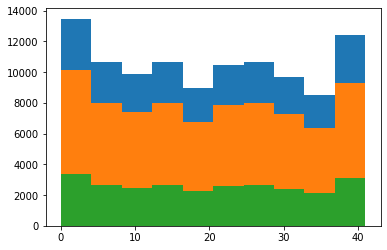

In [206]:
import matplotlib.pyplot as plt
plt.hist(train['category'])
plt.hist(train_df['category'])
plt.hist(valid_df['category'])

In [207]:
#for RGB images, set grayscale as False
#train_image = []
#for i in tqdm(range(train.shape[0])):
    #img = image.load_img('train/'+train['id'][i].astype('str')+'.png', target_size=(28,28,1), grayscale=False)
    #img = image.img_to_array(img)
    #img = img/255
    #train_image.append(img)
#X = np.array(train_image)

In [249]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.applications.mobilenet import MobileNetV2
from tensorflow.keras.applications.mobilenet import MobileNet as PTModel,preprocess_input
#from keras.applications.MobileNetV2 import preprocess_input
img_gen_args = dict(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.05, 
                              width_shift_range = 0.02, 
                              rotation_range = 3, 
                              shear_range = 0.01,
                              fill_mode = 'nearest',
                              zoom_range = 0.05,
                               preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    #print("shape",type(in_df),path_col,len(path_col),type(y_col),y_col)
    print(y_col)
    #print(in_df)
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print(base_dir)
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    print(type(df_gen))
    df_gen.filenames = in_df[path_col].values
    print("file",df_gen.filenames)
    df_gen.classes = np.stack(in_df[y_col].values,0)
    print("clas",df_gen.classes)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [250]:
num_classes = 42
IMG_SIZE = (224,224,3)
BATCH_SIZE = 24

In [226]:
num_classes = 42
input_shape = (224,224,3)
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

#my_new_model = Sequential()
#my_new_model.add(ResNet50(include_top=False, pooling='avg')#, weights=resnet_weights_path))
#my_new_model.add(MobileNetV2(input_shape=input_shape))
#my_new_model.add(Dense(42, activation='softmax'))

# Say not to train first layer (ResNet) model. It is already trained
#my_new_model.layers[0].trainable = False

In [227]:
#def create_model(input_shape):
#    # load MobileNetV2
#    model = MobileNetV2(input_shape=input_shape)
#    # remove the last fully connected layer
#    model.layers.pop()
#    # freeze all the weights of the model except the last 4 layers
#    for layer in model.layers[:-4]:
#        layer.trainable = False
#    # construct our own fully connected layer for classification
#    output = Dense(num_classes, activation="softmax")
#    # connect that dense layer to the model
#    output = output(model.layers[-1].output)
#    model = Model(inputs=model.inputs, outputs=output)
    # print the summary of the model architecture
#    model.summary()
    # training the model using rmsprop optimizer
#    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#    return model

In [228]:
#model = Sequential()
#model.add(MobileNetV2(input_shape=(224,224,3),weights='imagenet'))
#model.summary()
#model.add(Dense(42, activation="softmax"))
#model.summary()
# remove the last fully connected layer
#model.layers.pop()

IMG_SHAPE = (224, 224, 3)
# Create the base model from the pre-trained model MobileNet V2
base_model = MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
#feature_batch = base_model(image_batch)
#print(feature_batch.shape)
base_model.trainable = False
base_model.summary()

# TRY LATER ---------
#Add a classification head
#To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a 
#tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.
global_average_layer = GlobalAveragePooling2D()
#feature_batch_average = global_average_layer(feature_batch)
#print(feature_batch_average.shape)

prediction_layer = Dense(42,activation='softmax')
#prediction_batch = prediction_layer(feature_batch_average)
#print(prediction_batch.shape)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [230]:
from keras.optimizers import Adam
base_learning_rate = 0.0001
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=base_learning_rate), metrics=["accuracy"])
#model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
#              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#              metrics=['accuracy'])

#len(model.trainable_variables) -- TRY IT

In [ ]:
#initial_epochs = 10
#validation_steps=20

#loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)
#print("initial loss: {:.2f}".format(loss0))
#print("initial accuracy: {:.2f}".format(accuracy0))

#history = model.fit(train_batches,
#                    epochs=initial_epochs,
#                    validation_data=validation_batches)

In [233]:
model.fit_generator(train_gen, 
                         steps_per_epoch=train_gen.n//BATCH_SIZE,
                         #validation_data=(gen_X, gen_Y), 
                         epochs=20, 
                         #callbacks=callbacks_list,
                         #workers=2)
                   )

IndexError: list index out of range

In [ ]:
'''#This function extracts the dataset, and then uses the ImageDataGenerator keras utility class 
#to wrap the dataset in a Python generator (so the images only loads to memory by batches, not in one shot).

def load_data(data_dir):
    """This function downloads, extracts, loads, normalizes and one-hot encodes Flower Photos dataset"""
    # download the dataset and extract it
    #data_dir = get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    #                                     fname='flower_photos', untar=True)
    #data_dir = pathlib.Path(data_dir)
    #data_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
    data_dir = pathlib.Path(data_dir)
    # count how many images are there
    image_count = len(list(data_dir.glob('*/*.jpg')))
    print("Number of images:", image_count)
    # get all classes for this dataset (types of items) excluding .DS_Store file #folders are classes
    CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != ".DS_Store"])
    # 20% validation set 80% training set
    image_generator = ImageDataGenerator(rescale=1/255, validation_split=0.2)
    # make the training dataset generator
    train_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size,
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="training")
    # make the validation dataset generator
    test_data_gen = image_generator.flow_from_directory(directory=str(data_dir), batch_size=batch_size, 
                                                        classes=list(CLASS_NAMES), target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        shuffle=True, subset="validation")
    return train_data_gen, test_data_gen, CLASS_NAMES'''

In [ ]:
train_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/train/'
test_dir = '/Users/priya/Desktop/classes-master/shopee_product_detection/data/test/'